In [20]:
import sys
import os
import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
sys.path.append('../')
os.environ['JOBLIB_TEMP_FOLDER'] = "/mnt"
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import numpy as np
import seaborn as sns
import pandas as pd
import pymc3 as pm

SEED = [20100425, 20100234]

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Initial version taken [here](http://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html)

#### Alternatives are [here](https://am207.github.io/2017/wiki/hierarch.html)

In [8]:
# Data of the Eight Schools Model
J = 8
y = np.asarray([28,  8, -3,  7, -1,  1, 18, 12], dtype=float)
sigma = np.asarray([15, 10, 16, 11,  9, 11, 10, 18], dtype=float)
# tau = 25.

### Centered Model

In [9]:
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

In [10]:
with Centered_eight:
    short_trace = pm.sample(600, chains=2, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau_log__, mu]
100%|██████████| 1100/1100 [00:06<00:00, 166.83it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
pm.summary(short_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.507861,3.398686,0.180897,-1.450309,12.228669,270.0,0.999399
theta__0,6.505678,5.655085,0.254403,-4.505995,18.452476,382.0,0.999238
theta__1,5.157874,4.846276,0.217430,-4.420509,14.889013,378.0,1.000181
theta__2,4.117829,5.567482,0.220681,-7.445999,15.721262,539.0,0.999399
theta__3,4.875032,4.702325,0.200808,-4.274170,15.087240,445.0,0.999316
theta__4,3.587983,4.956192,0.219592,-6.563756,13.652766,310.0,1.000043
theta__5,4.338958,4.857719,0.215287,-4.456787,15.450502,261.0,0.999225
theta__6,6.550999,5.237904,0.256299,-3.346746,17.109287,326.0,0.999391
theta__7,5.040367,5.439874,0.212432,-4.678130,16.511256,444.0,0.999948
tau,4.078888,3.338446,0.223068,0.715852,10.469508,151.0,0.999521


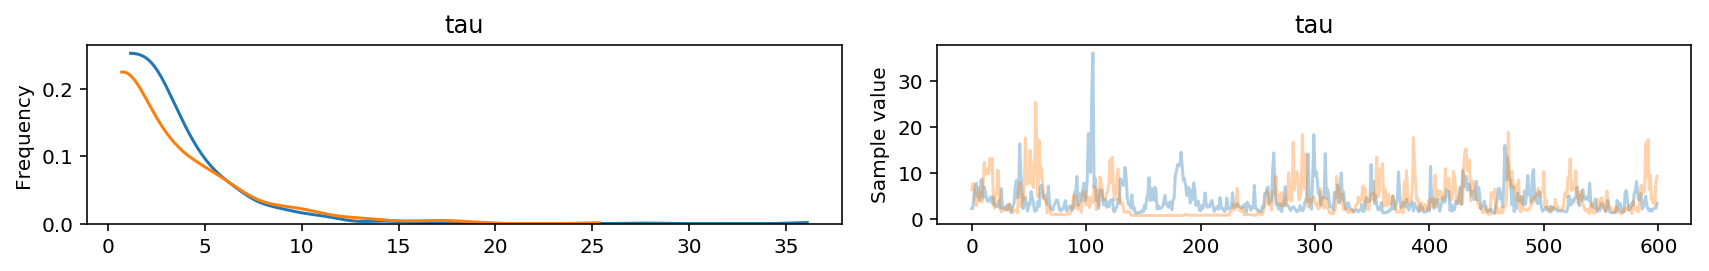

In [12]:
pm.traceplot(short_trace, varnames=['tau']);

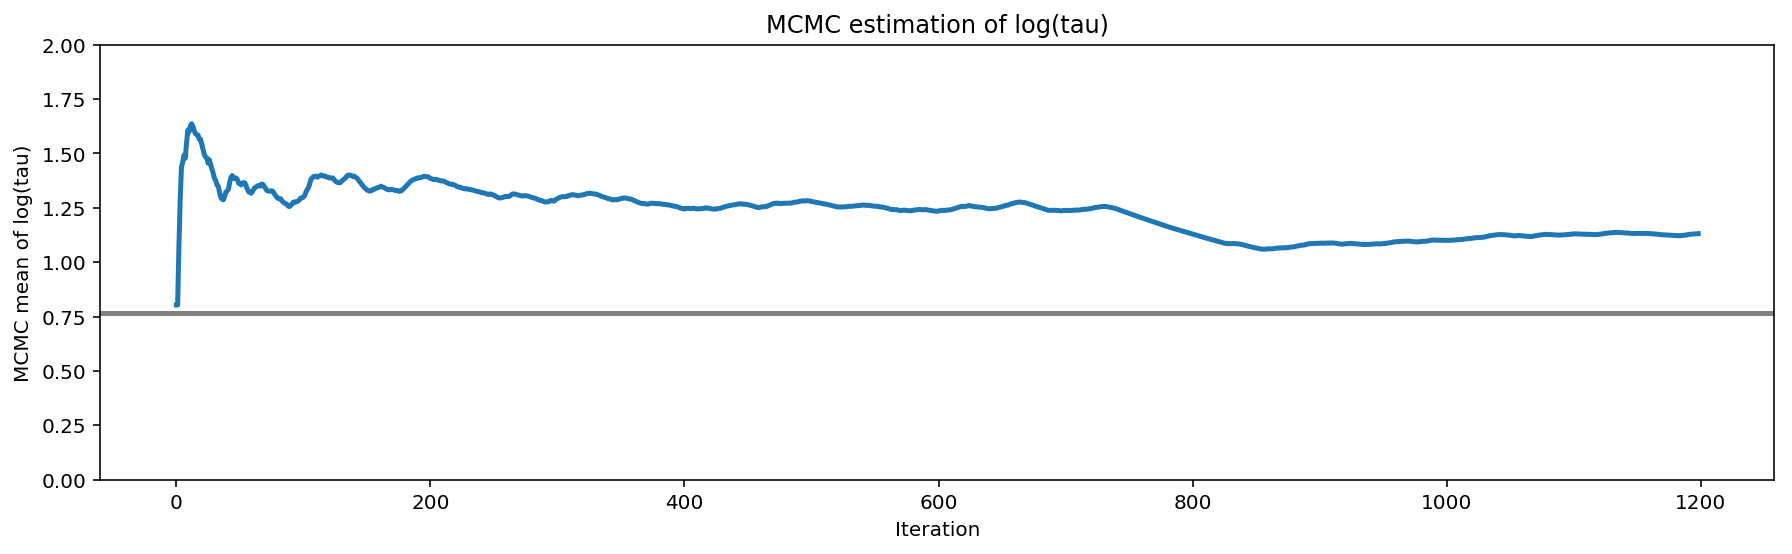

In [15]:
logtau = np.log(short_trace['tau'])
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)');

In [17]:
# display the total number and percentage of divergent
divergent = short_trace['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(short_trace)
print('Percentage of Divergent %.5f' % divperc)

Number of Divergent 25
Percentage of Divergent 0.04167


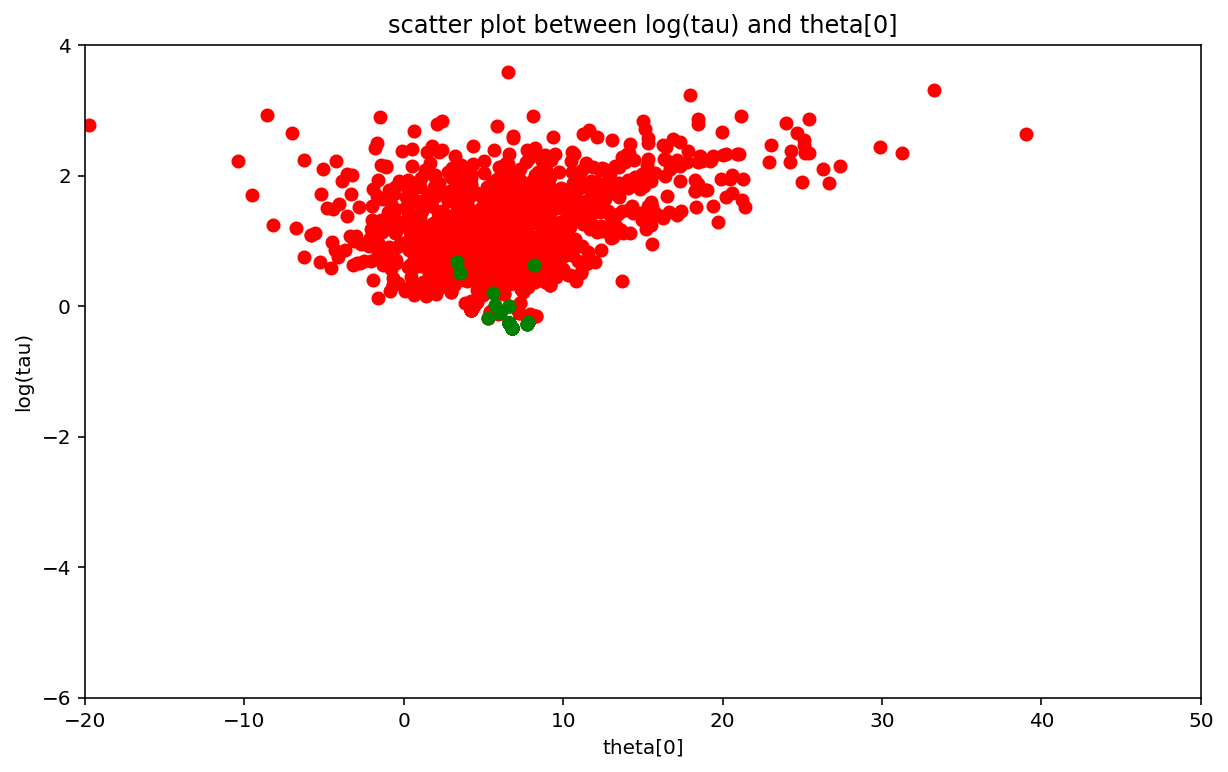

In [18]:
# scatter plot between log(tau) and theta[0]
# for the identifcation of the problematic neighborhoods in parameter space
theta_trace = short_trace['theta']
theta0 = theta_trace[:, 0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[divergent == 0], logtau[divergent == 0], color='r')
plt.scatter(theta0[divergent == 1], logtau[divergent == 1], color='g')
plt.axis([-20, 50, -6, 4])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]');

In [21]:
divergent_point = defaultdict(list)

chain_warn = short_trace.report._chain_warnings
for i in range(len(chain_warn)):
    for warning_ in chain_warn[i]:
        if warning_.step is not None and warning_.extra is not None:
            for RV in Centered_eight.free_RVs:
                para_name = RV.name
                divergent_point[para_name].append(warning_.extra[para_name])

for RV in Centered_eight.free_RVs:
    para_name = RV.name
    divergent_point[para_name] = np.asarray(divergent_point[para_name])
ii = 5

tau_log_d = divergent_point['tau_log__']
theta0_d = divergent_point['theta'][:, ii]
Ndiv_recorded = len(tau_log_d)

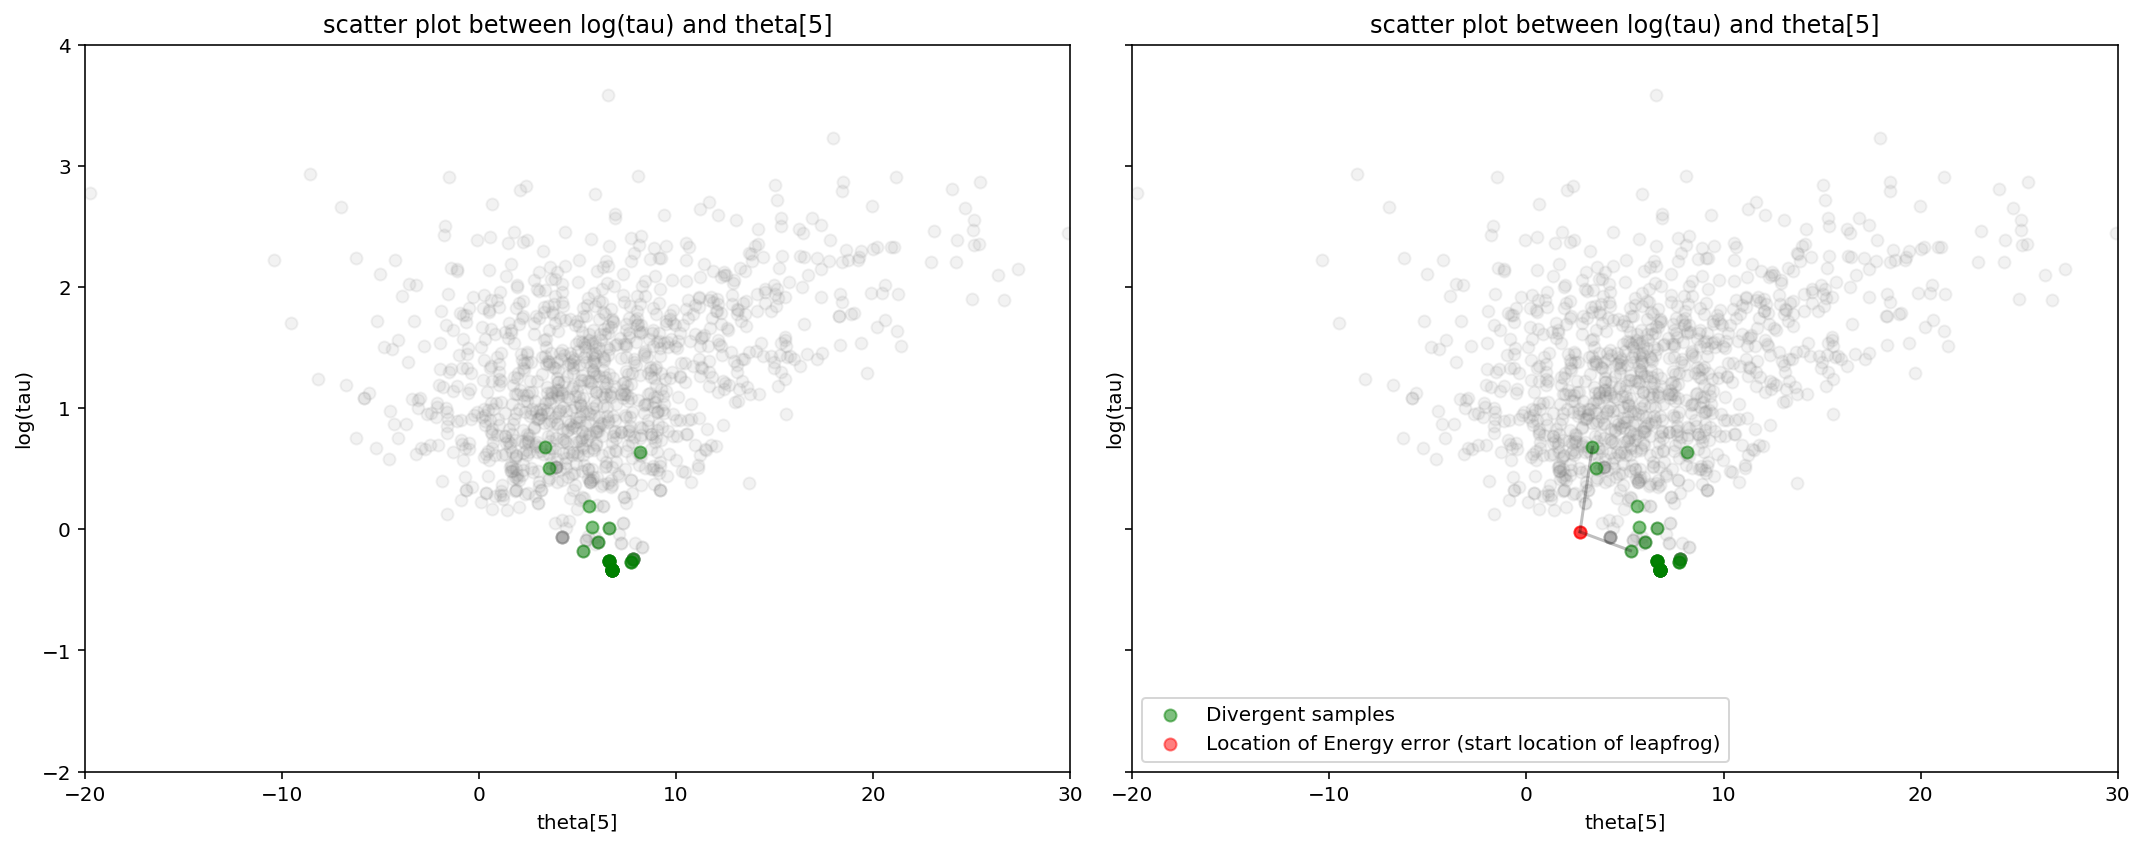

In [22]:
_, ax = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
ax[0].scatter(theta0[divergent == 0], logtau[divergent == 0], color='grey', alpha=.1)
ax[0].scatter(theta0[divergent == 1], logtau[divergent == 1], color='g', alpha=.5)
ax[0].axis([-20, 50, -6, 4])
ax[0].set_ylabel('log(tau)')
ax[0].set_xlabel('theta[%s]'%(ii))
ax[0].set_title('scatter plot between log(tau) and theta[%s]'%(ii))

ax[1].scatter(theta0[divergent == 0], logtau[divergent == 0],
              color='grey', alpha=.1)
ax[1].scatter(theta0[divergent == 1], logtau[divergent == 1],
              color='g', alpha=.5, label='Divergent samples')
ax[1].scatter(theta0_d, tau_log_d,
              color='r', alpha=.5, label='Location of Energy error (start location of leapfrog)')
ax[1].plot([theta0[divergent == 1][:Ndiv_recorded], theta0_d],
           [logtau[divergent == 1][:Ndiv_recorded], tau_log_d],
           'k-', alpha=.25)
ax[1].axis([-20, 30, -2, 4])
ax[1].set_ylabel('log(tau)')
ax[1].set_xlabel('theta[%s]'%(ii))
ax[1].set_title('scatter plot between log(tau) and theta[%s]'%(ii))
plt.legend()
plt.tight_layout();

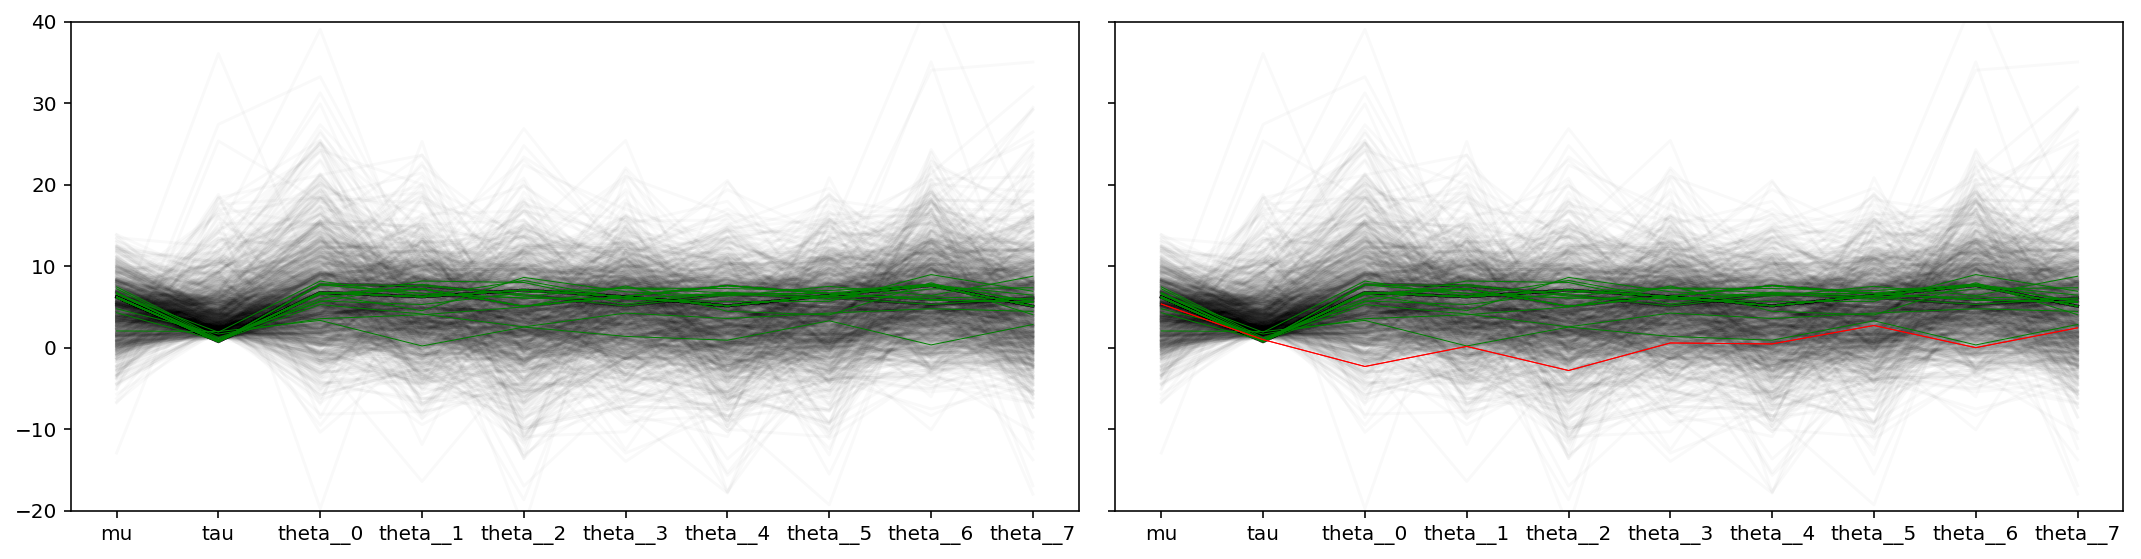

In [23]:
tracedf = pm.trace_to_dataframe(short_trace)
plotorder = ['mu', 'tau', 'theta__0', 'theta__1', 'theta__2', 'theta__3', 'theta__4',
       'theta__5', 'theta__6', 'theta__7']
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)
ax[0].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[0].plot(tracedf.values[divergent == 1].T, color='g', lw=.5)

ax[1].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[1].plot(tracedf.values[divergent == 1].T, color='g', lw=.5)
divsp = np.hstack([divergent_point['mu'][:,None],
                   np.exp(divergent_point['tau_log__'])[:,None],
                   divergent_point['theta']])
ax[1].plot(divsp.T, 'r', lw=.5)
plt.ylim([-20,40])
plt.xticks(range(10), plotorder)
plt.tight_layout();

In [24]:
# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace):
    # plot the trace of log(tau)
    pm.traceplot(trace, varnames=['tau'])

    # plot the estimate for the mean of log(τ) cumulating mean
    logtau = np.log(trace['tau'])
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log(tau)')
    plt.title('MCMC estimation of log(tau)')
    plt.show()

    # display the total number and percentage of divergent
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size/len(trace)
    print('Percentage of Divergent %.5f' % divperc)

    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space
    theta_trace = trace['theta']
    theta0 = theta_trace[:, 0]
    plt.figure(figsize=(10, 6))
    plt.scatter(theta0[divergent == 0], logtau[divergent == 0], color='r')
    plt.scatter(theta0[divergent == 1], logtau[divergent == 1], color='g')
    plt.axis([-20, 50, -6, 4])
    plt.ylabel('log(tau)')
    plt.xlabel('theta[0]')
    plt.title('scatter plot between log(tau) and theta[1]')
    plt.show()

In [25]:
with Centered_eight:
    longer_trace = pm.sample(4000, chains=2, tune=1000, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/conda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [theta, tau_log__, mu]
100%|██████████| 5000/5000 [00:29<00:00, 166.89it/s]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 187 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


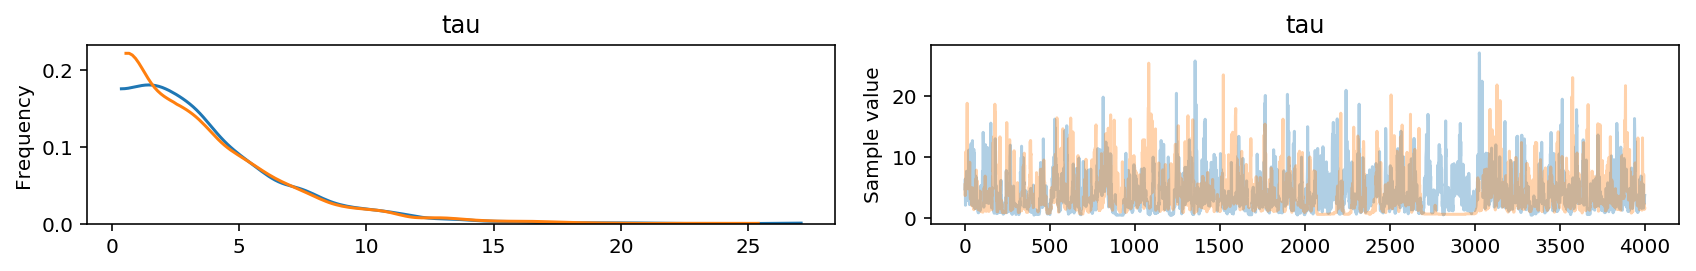

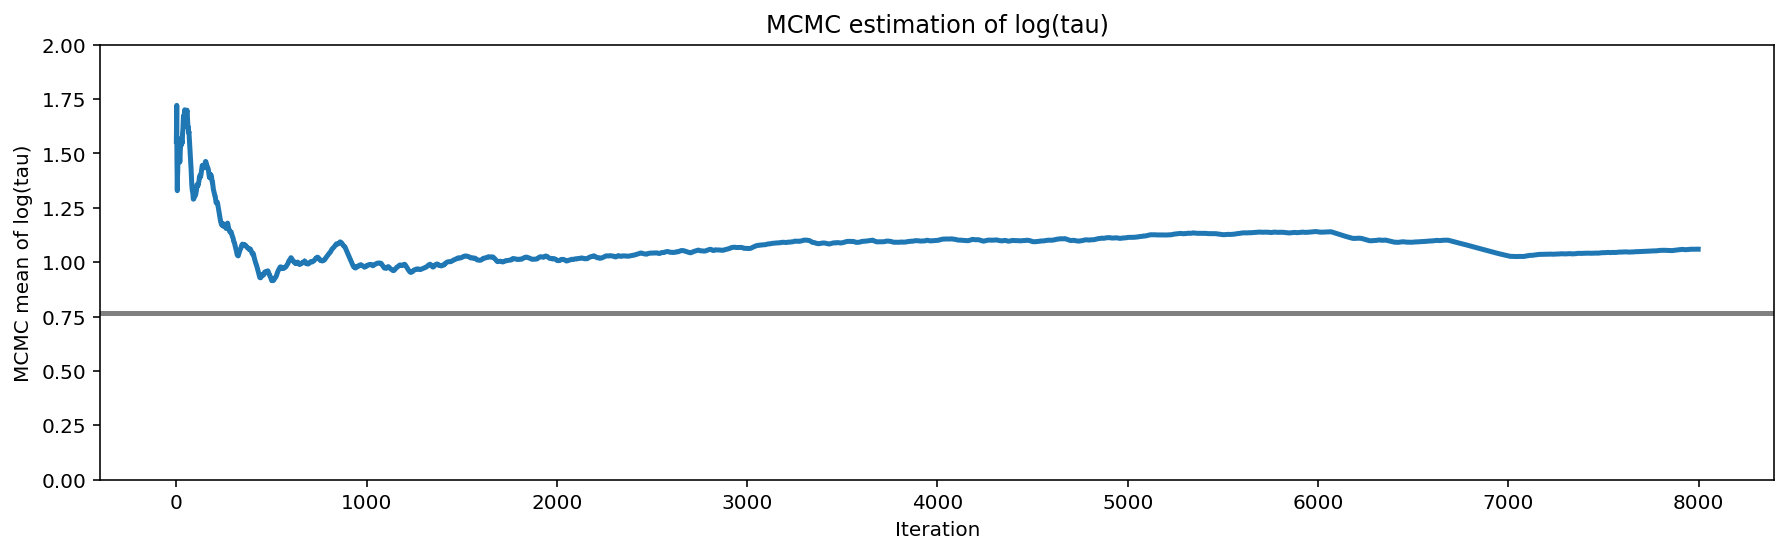

Number of Divergent 187
Percentage of Divergent 0.04675


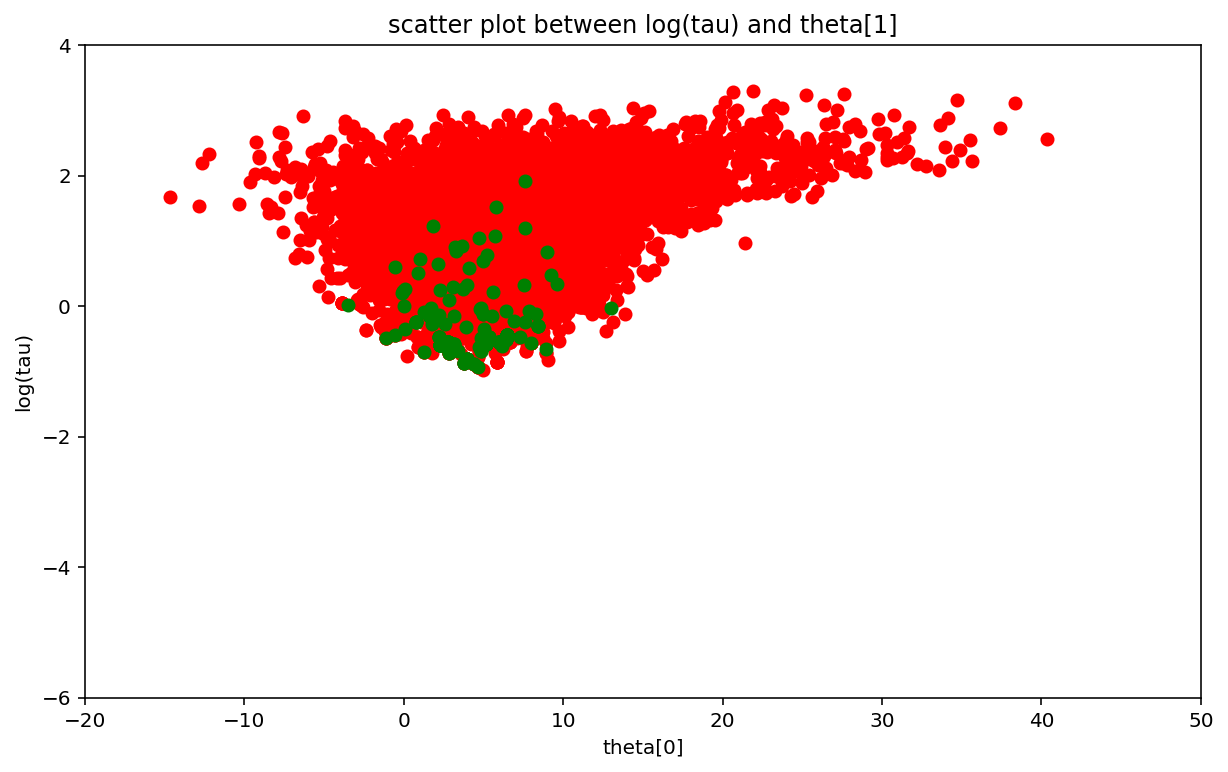

In [26]:
report_trace(longer_trace)

In [28]:
pm.summary(longer_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.366520,3.244539,0.092008,-2.430082,10.486453,1135.0,0.999880
theta__0,6.409167,5.595886,0.127256,-3.891261,18.167053,1852.0,1.000041
theta__1,5.035904,4.713481,0.102844,-4.048832,14.910447,2291.0,0.999945
theta__2,3.923471,5.456474,0.108177,-8.007299,14.429473,2049.0,0.999987
theta__3,4.708329,4.800342,0.105684,-5.799141,13.677683,2382.0,0.999974
theta__4,3.472084,4.694020,0.103750,-5.674223,13.055835,2061.0,0.999955
theta__5,3.955383,4.964748,0.102652,-5.999811,13.988135,1842.0,1.000006
theta__6,6.505707,5.169696,0.119949,-3.141639,17.202645,1646.0,1.000452
theta__7,4.844135,5.248182,0.096888,-5.625001,15.428109,2655.0,0.999877
tau,3.963879,3.174960,0.123698,0.395108,10.289170,445.0,1.000309
